<a href="https://colab.research.google.com/github/omridrori/generative-models/blob/main/clip.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import torch 
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import IPython.display as ipd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim

import kornia.augmentation as K
from CLIP import clip
from torchvision import transforms

from PIL import Image
import numpy as np
import math

from matplotlib import pyplot as plt
from fastprogress.fastprogress import master_bar, progress_bar
from IPython.display import HTML
from base64 import b64encode

In [4]:
!pip install -q  ftfy regex tqdm omegaconf pytorch-lightning fastprogress kornia &> /dev/null

In [5]:
print("Downloading CLIP and installing requirements")
!git clone https://github.com/openai/CLIP                 &> /dev/null
!pip install -q  ftfy regex tqdm omegaconf pytorch-lightning &> /dev/null

In [ ]:
from CLIP import clip 
from torchvision import transforms 
import torch.nn.functional as F 
from tqdm.notebook import tqdm 


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
perceptor = clip.load('ViT-B/32', jit=False)[0].eval().requires_grad_(False).to(device)
print(perceptor.visual.input_resolution) # 224px a side

In [4]:
# Embed some text
text_embed = perceptor.encode_text(clip.tokenize("A watercolor painting of the sunset over a mountain range").to(device)).float()
text_embed.shape

torch.Size([1, 512])

In [5]:
text_embed

tensor([[ 1.2872e-01,  1.1506e-02,  9.8921e-02,  1.9178e-01, -1.6456e-02,
         -3.1813e-01, -2.0628e-01, -2.8226e-01, -2.2122e-01,  4.3614e-01,
          1.9254e-01, -6.1615e-01,  3.4627e-01, -2.2761e-01,  1.3441e-01,
          4.1560e-01, -4.2705e-01,  5.7785e-01, -7.2960e-03,  4.5115e-01,
          2.3435e-01,  7.9956e-03, -3.4687e-01, -1.4766e-01, -2.5531e-02,
          2.1071e-01,  1.8176e-01, -1.9941e-01,  2.6031e-01, -1.8956e-01,
         -1.1461e-01,  3.3278e-01,  1.2480e-01, -5.4962e-01, -7.7376e-01,
          4.6024e-01,  3.5616e-01,  6.4809e-03, -3.8317e-02, -1.5584e-01,
         -1.7694e-01,  2.8094e-01, -1.9267e-01, -3.4622e-03, -1.4242e-01,
          8.8192e-02,  2.7608e-01, -4.4325e-01,  3.2960e-01, -3.2915e-01,
          8.8055e-02, -3.1314e-01,  2.5716e-01,  3.5081e-01, -1.9247e-01,
         -1.6646e-01, -7.6056e-02, -2.6452e-02,  2.4687e-01, -1.8251e-01,
         -2.7589e-01, -4.1685e-01, -1.2597e-02, -6.1874e-02,  9.6408e-02,
         -2.7319e-01, -3.0980e-01,  9.

In [6]:
im = torch.rand(1, 3, 224, 224) 
## from clip paper to normlize for the values seen in their training
normalize = transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],std=[0.26862954, 0.26130258, 0.27577711])
image_embed = perceptor.encode_image(normalize(im).to(device)).float()
image_embed.shape

torch.Size([1, 512])

In [7]:
def clip_loss_basic(im, text_embed):
  image_embed = perceptor.encode_image(normalize(im).to(device)).float()
  loss = torch.mean((image_embed - text_embed)**2)**0.5 ##see how close the embbedings by mse
  return loss

clip_loss_basic(im, text_embed)

tensor(0.4812)

  0%|          | 0/200 [00:00<?, ?it/s]

0 tensor(0.4734, grad_fn=<PowBackward0>)
50 tensor(0.2550, grad_fn=<PowBackward0>)
100 tensor(0.1923, grad_fn=<PowBackward0>)
150 tensor(0.1767, grad_fn=<PowBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


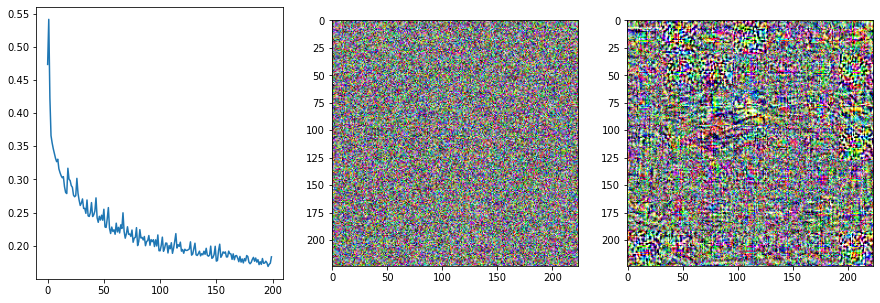

In [11]:
text_embed = perceptor.encode_text(clip.tokenize("A watercolor painting of the sunset over a mountain range").to(device)).float()
im = torch.rand(1, 3, 224, 224)
im.requires_grad = True
start_im = im.detach().clone()
optimizer = torch.optim.SGD([im], lr=700)

losses = [] 

for i in tqdm(range(200)):

  
  optimizer.zero_grad()

  
  loss = clip_loss_basic(im, text_embed)

  if i % 50 == 0:
    print(i, loss)
  losses.append(loss.detach().item())

  loss.backward()
  optimizer.step() 
  
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].plot(losses)
axs[1].imshow(start_im.squeeze().permute(1, 2, 0))
axs[2].imshow(im.squeeze().detach().permute(1, 2, 0))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


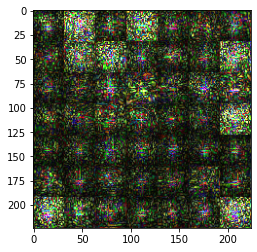

In [13]:
plt.imshow(torch.abs(im.detach()-start_im).squeeze().permute(1, 2, 0)) 

  0%|          | 0/200 [00:00<?, ?it/s]

0 tensor(0.8958, grad_fn=<MeanBackward0>)
50 tensor(0.7800, grad_fn=<MeanBackward0>)
100 tensor(0.7787, grad_fn=<MeanBackward0>)
150 tensor(0.7521, grad_fn=<MeanBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


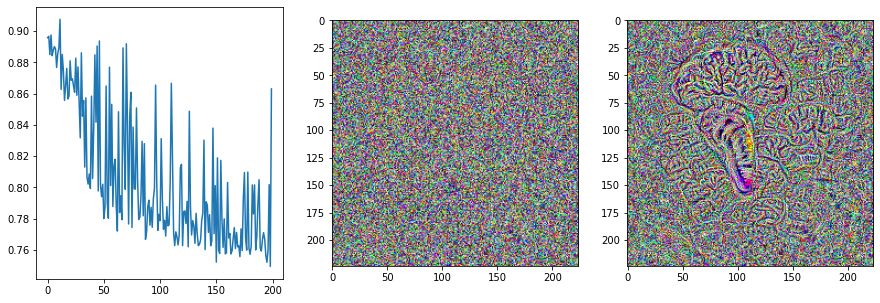

In [18]:
#@title Take Two:

# Specifying some transforms to apply to our image:
tfms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomAffine(5),
    transforms.ColorJitter(),
    transforms.GaussianBlur(5),
])

# Our new and improved loss function
def clip_loss(im, text_embed):
  image_embed = perceptor.encode_image(tfms(im).to(device)).float()
  input_normed = F.normalize(image_embed.unsqueeze(1), dim=2)
  embed_normed = F.normalize(text_embed.unsqueeze(0), dim=2)
  dists = input_normed.sub(embed_normed).norm(dim=2).div(2).arcsin().pow(2).mul(2) # Squared Great Circle Distance
  return dists.mean()

# The target text as a parameter:
prompt = "brain" #@param
text_embed = perceptor.encode_text(clip.tokenize(prompt).to(device)).float()

# The image we'll be optimizing
im = torch.rand(1, 3, 224, 224)
im.requires_grad = True

# Make a copy of the starting image
start_im = im.detach().clone()

# The optimizer
learning_rate = 50 #@param
optimizer = torch.optim.SGD([im], lr=learning_rate)

losses = [] # Keep track of our losses (RMSE values)

n_iterations = 200 #@param
for i in tqdm(range(n_iterations)):

  # Reset everything related to gradient calculations
  optimizer.zero_grad()

  # Calculate our loss
  loss = clip_loss(im.clip(0, 1), text_embed) # note .clip(0, 1)

  # Store the loss for later
  if i % 50 == 0:
    print(i, loss)
  losses.append(loss.detach().item())

  # Backpropagate the loss and use it to update the parameters
  loss.backward() # This does all the gradient calculations
  optimizer.step() # The optimizer does the update

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].plot(losses)
axs[1].imshow(start_im.squeeze().permute(1, 2, 0))
axs[2].imshow(im.squeeze().detach().permute(1, 2, 0))

In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

def sinc(x):
    return torch.where(x != 0, torch.sin(math.pi * x) / (math.pi * x), x.new_ones([]))
 
 
def lanczos(x, a):
    cond = torch.logical_and(-a < x, x < a)
    out = torch.where(cond, sinc(x) * sinc(x/a), x.new_zeros([]))
    return out / out.sum()
 
 
def ramp(ratio, width):
    n = math.ceil(width / ratio + 1)
    out = torch.empty([n])
    cur = 0
    for i in range(out.shape[0]):
        out[i] = cur
        cur += ratio
    return torch.cat([-out[1:].flip([0]), out])[1:-1]

class Prompt(nn.Module):
    def __init__(self, embed, weight=1., stop=float('-inf')):
        super().__init__()
        self.register_buffer('embed', embed)
        self.register_buffer('weight', torch.as_tensor(weight))
        self.register_buffer('stop', torch.as_tensor(stop))
 
    def forward(self, input):
        input_normed = F.normalize(input.unsqueeze(1), dim=2)
        embed_normed = F.normalize(self.embed.unsqueeze(0), dim=2)
        dists = input_normed.sub(embed_normed).norm(dim=2).div(2).arcsin().pow(2).mul(2)
        dists = dists * self.weight.sign()
        return self.weight.abs() * replace_grad(dists, torch.maximum(dists, self.stop)).mean()

class MakeCutouts(nn.Module):
    def __init__(self, cut_size, cutn, cut_pow=1.):
        super().__init__()
        self.cut_size = cut_size
        self.cutn = cutn
        self.cut_pow = cut_pow
        self.augs = nn.Sequential(
            K.RandomHorizontalFlip(p=0.5),
            K.RandomSharpness(0.3,p=0.4),
            K.RandomAffine(degrees=30, translate=0.1, p=0.8, padding_mode='border'),
            K.RandomPerspective(0.2,p=0.4),
            K.ColorJitter(hue=0.01, saturation=0.01, p=0.7))
        self.noise_fac = 0.1 

    def forward(self, input):
        sideY, sideX = input.shape[2:4]
        max_size = min(sideX, sideY)
        min_size = min(sideX, sideY, self.cut_size)
        cutouts = []
        for _ in range(self.cutn):
            size = int(torch.rand([])**self.cut_pow * (max_size - min_size) + min_size)
            offsetx = torch.randint(0, sideX - size + 1, ())
            offsety = torch.randint(0, sideY - size + 1, ())
            cutout = input[:, :, offsety:offsety + size, offsetx:offsetx + size]
            cutouts.append(resample(cutout, (self.cut_size, self.cut_size)))
        batch = self.augs(torch.cat(cutouts, dim=0))
        if self.noise_fac:
            facs = batch.new_empty([self.cutn, 1, 1, 1]).uniform_(0, self.noise_fac)
            batch = batch + facs * torch.randn_like(batch)
        return batch

def resample(input, size, align_corners=True):
    n, c, h, w = input.shape
    dh, dw = size
 
    input = input.view([n * c, 1, h, w])
 
    if dh < h:
        kernel_h = lanczos(ramp(dh / h, 2), 2).to(input.device, input.dtype)
        pad_h = (kernel_h.shape[0] - 1) // 2
        input = F.pad(input, (0, 0, pad_h, pad_h), 'reflect')
        input = F.conv2d(input, kernel_h[None, None, :, None])
 
    if dw < w:
        kernel_w = lanczos(ramp(dw / w, 2), 2).to(input.device, input.dtype)
        pad_w = (kernel_w.shape[0] - 1) // 2
        input = F.pad(input, (pad_w, pad_w, 0, 0), 'reflect')
        input = F.conv2d(input, kernel_w[None, None, None, :])
 
    input = input.view([n, c, h, w])
    return F.interpolate(input, size, mode='bicubic', align_corners=align_corners)

class ReplaceGrad(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x_forward, x_backward):
        ctx.shape = x_backward.shape
        return x_forward
 
    @staticmethod
    def backward(ctx, grad_in):
        return None, grad_in.sum_to_size(ctx.shape)
 
 
replace_grad = ReplaceGrad.apply 

In [8]:
perceptor = clip.load('ViT-B/32', jit=False)[0].eval().requires_grad_(False).to(device)
normalize = transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                                 std=[0.26862954, 0.26130258, 0.27577711])
cut_size = perceptor.visual.input_resolution
cutn=64
cut_pow=1
make_cutouts = MakeCutouts(cut_size, cutn, cut_pow=cut_pow)

100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 139MiB/s]


In [9]:
class ImStack(nn.Module):
 
  def __init__(self, n_layers=3, base_size=32, scale=2,
               init_image=None, out_size=256, decay=0.7):
    """Constructs the Image Stack

    Args:
        TODO
    """
    super().__init__()
    self.n_layers = n_layers
    self.base_size = base_size
    self.sig = nn.Sigmoid()
    self.layers = []

    for i in range(n_layers):
        side = base_size * (scale**i)
        tim = torch.randn((3, side, side)).to(device)*(decay**i)
        self.layers.append(tim)

    self.scalers = [nn.Upsample(scale_factor=out_size/(l.shape[1]), mode='bilinear', align_corners=False) for l in self.layers]
    
    self.preview_scalers = [nn.Upsample(scale_factor=224/(l.shape[1]), mode='bilinear', align_corners=False) for l in self.layers]
    
    if init_image != None: # Given a PIL image, decompose it into a stack
      downscalers = [nn.Upsample(scale_factor=(l.shape[1]/out_size), mode='bilinear', align_corners=False) for l in self.layers]
      final_side = base_size * (scale ** n_layers)
      im = torch.tensor(np.array(init_image.resize((out_size, out_size)))/255).clip(1e-03, 1-1e-3) # Between 0 and 1 (non-inclusive)
      im = im.permute(2, 0, 1).unsqueeze(0).to(device) # torch.log(im/(1-im))
      for i in range(n_layers):self.layers[i] *= 0 # Sero out the layers
      for i in range(n_layers):
        side = base_size * (scale**i)
        out = self.forward()
        residual = (torch.logit(im) - torch.logit(out))
        Image.fromarray((torch.logit(residual).detach().cpu().squeeze().permute([1, 2, 0]) * 255).numpy().astype(np.uint8)).save(f'residual{i}.png')
        self.layers[i] = downscalers[i](residual).squeeze()
    
    for l in self.layers: l.requires_grad = True

  def forward(self):
    im = self.scalers[0](self.layers[0].unsqueeze(0))
    for i in range(1, self.n_layers):
      im += self.scalers[i](self.layers[i].unsqueeze(0))
    return self.sig(im)

  def preview(self, n_preview=2):
    im = self.preview_scalers[0](self.layers[0].unsqueeze(0))
    for i in range(1, n_preview):
      im += self.preview_scalers[i](self.layers[i].unsqueeze(0))
    return self.sig(im)
  
  def to_pil(self):
    return Image.fromarray((self.forward().detach().cpu().squeeze().permute([1, 2, 0]) * 255).numpy().astype(np.uint8))

  def preview_pil(self):
    return Image.fromarray((self.preview().detach().cpu().squeeze().permute([1, 2, 0]) * 255).numpy().astype(np.uint8))

  def save(self, fn):
    self.to_pil().save(fn)

  def plot_layers(self):
    fig, axs = plt.subplots(1, self.n_layers, figsize=(15, 5))
    for i in range(self.n_layers):
      im = (self.sig(self.layers[i].unsqueeze(0)).detach().cpu().squeeze().permute([1, 2, 0]) * 255).numpy().astype(np.uint8)
      axs[i].imshow(im)

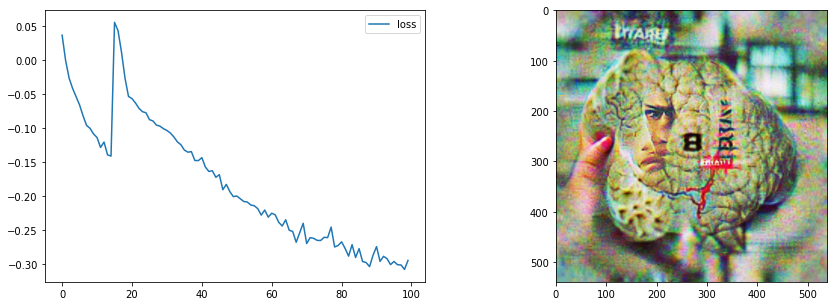

In [11]:
#@title Settings
# Somewhere to store images that will be used for the video
!rm -r steps
!mkdir -p steps

# A list of positive prompts
ptexts = ['brain'] #@param
lr=0.25 #@param
# init_image=None #@param
weight_decay=1e-5 #@param
n_iter=100 #@param
out_size=540 #@param
base_size=20 #@param
n_layers=4 #@param
scale=3 #@param



p_prompts = []
for pr in ptexts:
  embed = perceptor.encode_text(clip.tokenize(pr).to(device)).float()
  p_prompts.append(Prompt(embed, 1, float('-inf')).to(device)) # 1 is the weight

# SOme negative prompts
n_prompts = []
for pr in ["Random noise", 'saturated rainbow RGB deep dream']:
  embed = perceptor.encode_text(clip.tokenize(pr).to(device)).float()
  n_prompts.append(Prompt(embed, 0.5, float('-inf')).to(device)) # 0.5 is the weight

# The ImageStack - trying a different scale and n_layers
ims = ImStack(base_size=base_size, scale=scale, n_layers=n_layers, out_size=out_size, decay=0.4)

optimizer = optim.Adam(ims.layers, lr=lr, weight_decay=weight_decay)
losses = []

# Some fancier progress bar stuff (this is a little hacky since I stole it from another project of mine that wasn't written for public consumption!)
mb = master_bar(range(1))
mb.names=['loss']
mb.graph_fig, axs = plt.subplots(1, 2, figsize=(15, 5)) # For custom display
mb.graph_ax = axs[0]
mb.img_ax = axs[1]
mb.graph_out = display(mb.graph_fig, display_id=True)

for p in mb:
  for i in progress_bar(range(n_iter), parent=mb):
    optimizer.zero_grad()

    if i < 15: # Save time by skipping the cutouts and focusing on the lower layers 
      im = ims.preview(n_preview=1 + i//20 )
      iii = perceptor.encode_image(normalize(im)).float()
    else:
      im = ims()
      iii = perceptor.encode_image(normalize(make_cutouts(im))).float()
    
    l = 0
    for prompt in p_prompts:
      l += prompt(iii)
    for prompt in n_prompts:
      l -= prompt(iii)

    losses.append(float(l.detach().cpu()))
    l.backward() # Backprop
    optimizer.step() # Update

    # Show progress and loss plot
    mb.update_graph([[range(len(losses)), losses]])

    # View and save images every few iterations
    save_every = 5
    if i % save_every == 0:
      img = ims.to_pil()
      mb.img_ax.imshow(img)
      mb.graph_out.update(mb.graph_fig)
      img.save(f'steps/step{len(losses)//save_every:04}.png')


In [14]:
!git remote add origin https://github.com/omridrori/omridrori.git
!git branch -M main
!git push -u origin main

fatal: not a git repository (or any of the parent directories): .git
fatal: not a git repository (or any of the parent directories): .git
fatal: not a git repository (or any of the parent directories): .git
